In [1]:
from matplotlib.pyplot import figure
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy, ema_logging, ScalarOutcome

import pickle
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
### Step 0: Setting up the model input

In [3]:
# Define the desired problem formulation here
pf = 3
model, _ = get_model_for_problem_formulation(pf)

In [4]:
#A small uncertainty analysis has been ran.
#The goal is to discover the range of values for the outcomes
#This range serves as an input for the Epsilon values

from ema_workbench import Samplers

from ema_workbench import MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000 #These values for n_scenario's and n_policies are high enough to have representative outcomes
n_policies = 50    #But low enough so the model runs in ~1hr

use_pickle1 = False
if use_pickle1:
    with open('data/MORDM_prep.pickle','rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, n_policies, uncertainty_sampling=Samplers.LHS)
    
    with open('data/MORDM_prep.pickle',"wb") as filehandler:
        pickle.dump(results,filehandler)
        
experiments, outcomes = results

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 50 policies * 1 model(s) = 50000 experiments
100%|██████████████████████████████████| 50000/50000 [1:06:54<00:00, 12.46it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [5]:
#Make a dictionary which defines the range for every outcome
range_outcome= {}
for i in outcomes:
    range_outcome[i]=outcomes[i].max()-outcomes[i].min()

#Create a list with epsilon values that can be used in the analysis
#1/15 of the range creates epsilon values that generates enough pareto-optimal policies 
list_epsilons = []
for i in range_outcome:
    print(i)
    list_epsilons.append(range_outcome[i]/15)    

A.1 Total Costs
A.1_Expected Number of Deaths
A.2 Total Costs
A.2_Expected Number of Deaths
A.3 Total Costs
A.3_Expected Number of Deaths
A.4 Total Costs
A.4_Expected Number of Deaths
A.5 Total Costs
A.5_Expected Number of Deaths
RfR Total Costs
Expected Evacuation Costs


In [6]:
#We do not understand yet why we need a reference_value, these values are from the std document of dike_model_simulation.py

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}
#comparing scenario's with the reference to select scenario's fitted for the problem
for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

### Step 1: Generate optimal policies

In [7]:
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so choose a large number to analyse trends. 

nfe = 300000

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

len_out = len(model.outcomes.keys()) #This adjusts the size of Hypervolume to the problem formulation
epsilon = list_epsilons   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0]*len_out, maximum=[1.01]*len_out),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle2 = False
if use_pickle2:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model,n_processes=10) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  uncertainty_sampling=Samplers.LHS)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

[MainProcess/INFO] pool started with 10 workers
300002it [7:49:29, 10.65it/s]                                                  
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


In [8]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,31,100
2,0.0,93,1196
3,0.0,132,2283
4,0.0,174,3377
...,...,...,...
293,0.0,328,295566
294,0.0,328,296569
295,0.0,329,297577
296,0.0,329,298584


In [9]:
outcomes = results[list(model.outcomes.keys())] #This makes sure that the outcomes are split from the levers/uncertainties 
outcomes.head()

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,6.476091e+07,0.010173,5.493766e+07,0.02289,7.439105e+07,0.02424,4.350504e+06,0.000888,9.301635e+06,0.003673,0.0,3475.531587


C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


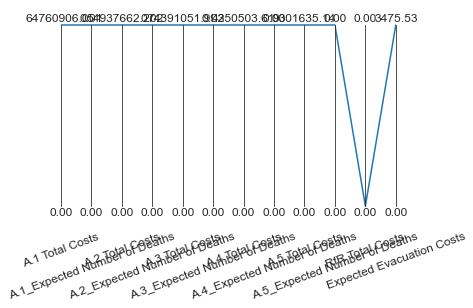

In [10]:
from ema_workbench.analysis import parcoords

#making a pairplot
import matplotlib.pyplot as plt

limits = parcoords.get_limits(outcomes)
limits.loc[0, outcomes.keys()] = 0

axes = parcoords.ParallelAxes(limits, fontsize=12, rot=20)
axes.plot(outcomes)
#plt.savefig(f"images/ParallelAxes_pf{pf}.svg")
plt.show()

In [11]:
convergence
#as seen, the hypervolume stays 0, this indicates an error. 

,hypervolume,epsilon_progress,nfe
0,0.0,0,0
1,0.0,31,100
2,0.0,93,1196
3,0.0,132,2283
4,0.0,174,3377
...,...,...,...
293,0.0,328,295566
294,0.0,328,296569
295,0.0,329,297577
296,0.0,329,298584


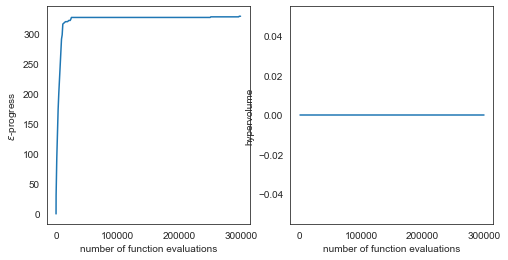

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Step 2: Re-evaluate candidate solutions under uncertainty

In [13]:
from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so chose a large number to analyse trends. 

nfe = 100

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

len_out = len(model.outcomes.keys()) #This adjusts the size of Epsilon and Hypervolume to the problem formulation
epsilon = [2] * len_out   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0]*len_out, maximum=[1.01]*len_out),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle3 = True
if use_pickle3:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  n_processes=10,
                                                  uncertainty_sampling=Samplers.LHS)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

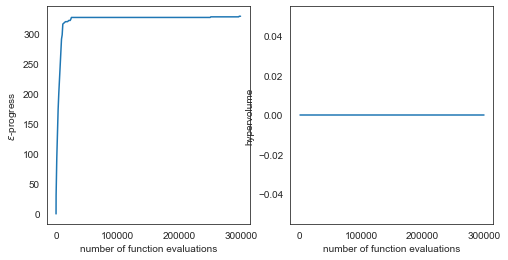

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Define criteria and select policies

In [15]:
years = 200                     # Current preferred timeframe
A3_deaths_per_year = 0.001      # Translates roughly 1 in 100:000 yearly chance of dike breakage in A.3 ring
other_deaths_per_year = 0.025   # Translates roughly 1 in  10:000 yearly chance of dike breakage in other dike rings
max_A3_total_costs = 170000000  # Our max preferred costs
max_rfr_costs = 1950000000      # Rijkswaterstaat budget of 2.3 billion minus 350 million for our compensation
max_evacuation_costs = 1000000  # No real reason

In [16]:
print(list(outcomes.keys()))

['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']


In [17]:
criteria_dict = {}
if pf == 3:
    # Sum the deaths for all other dike rings
    results["Expected Number of other Deaths"] = results[[f'A.{dike_ring}_Expected Number of Deaths' for dike_ring in [1, 2, 4, 5]]].sum(axis=1)
    
    # Define the citerea
    criteria_dict['A.3_Expected Number of Deaths'] = A3_deaths_per_year * years
    criteria_dict['A.3 Total Costs'] = max_A3_total_costs
    criteria_dict['RfR Total Costs'] = max_rfr_costs
    criteria_dict['Expected Number of other Deaths'] = other_deaths_per_year * years
    criteria_dict['Expected Evacuation Costs'] = max_evacuation_costs
    
else:
    print(f"TODO: Implement these criteria for problem formulation {pf}")

In [18]:
# Filter results DataFrame for criteria
logical = None
policies = results

print(f"Number of logical policies: {len(policies.index)}")
for column, value in criteria_dict.items():
    logical = policies[column] <= value
    print(f"Number of logical policies: {len(policies.index)} (after filtering {column} <= {value})")
    policies = policies[logical]

Number of logical policies: 1
Number of logical policies: 1 (after filtering A.3_Expected Number of Deaths <= 0.2)
Number of logical policies: 1 (after filtering A.3 Total Costs <= 170000000)
Number of logical policies: 1 (after filtering RfR Total Costs <= 1950000000)
Number of logical policies: 1 (after filtering Expected Number of other Deaths <= 5.0)
Number of logical policies: 1 (after filtering Expected Evacuation Costs <= 1000000)


In [19]:
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Number of other Deaths
0,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,0,0,0.037624


In [20]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [21]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle4 = True
if use_pickle4:
    with open(f"data/MORDM_results2_pf{pf}.pickle","rb") as filehandler:
        results2 = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 250
    with MultiprocessingEvaluator(model) as evaluator:
        results2 = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)
    # Save results in Pickle file
    with open(f"data/MORDM_results2_pf{pf}.pickle","wb") as filehandler:
        pickle.dump(results2,filehandler)

In [22]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [23]:
experiments2, outcomes2 = results2

overall_scores = {}
for policy in np.unique(experiments2['policy']):
    scores = {}
    
    logical = experiments2['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes2[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,7.161799e+15,0.000066,2.498944e+15,0.000007,5.392860e+16,1.989447e-02,2.097705e+14,0.000001,1.324163e+16,0.000255,0.0,4.790793e+07
1,3.440804e+15,0.000148,1.939085e+16,0.010983,1.941910e+15,8.167507e-04,6.573053e+14,0.000040,8.516706e+15,0.001062,0.0,0.000000e+00
10,7.118177e+16,0.012189,3.543137e+16,0.019674,6.164031e+15,2.948548e-03,4.654830e+14,0.000030,2.302068e+16,0.014621,0.0,0.000000e+00
100,7.598891e+17,0.044850,5.694968e+16,0.004619,1.641297e+17,5.792461e-02,1.276774e+15,0.000033,2.658105e+15,0.000135,0.0,2.103495e+08
1000,2.134357e+17,0.086646,1.567670e+16,0.003918,1.317386e+17,3.678829e-01,2.374913e+15,0.000311,2.181018e+16,0.019373,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
995,8.168513e+16,0.001301,5.138431e+16,0.003997,1.149184e+13,2.685401e-08,8.893605e+14,0.000011,2.223455e+16,0.001421,0.0,6.388590e+07
996,2.018536e+17,0.090379,3.253734e+16,0.014545,3.267141e+14,1.937331e-05,1.674731e+15,0.000341,2.805165e+15,0.000444,0.0,0.000000e+00
997,1.753226e+00,0.000000,4.724853e+16,0.021358,1.257363e+17,3.614289e-01,5.653003e+14,0.000056,2.809331e+15,0.002393,0.0,0.000000e+00
998,1.342387e+17,0.037791,2.078001e+16,0.005573,6.817051e+14,4.731971e-04,2.128418e+15,0.000455,1.312303e+16,0.004552,0.0,0.000000e+00


C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


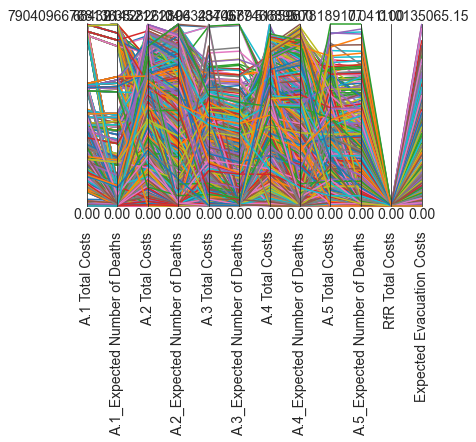

In [24]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

### Step 3: Give scores using maximum regret

In [25]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [26]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\72777

In [27]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [28]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\72777

In [29]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [30]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\727777919.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Thomas\AppData\Local\Temp\ipykernel_8252\72777

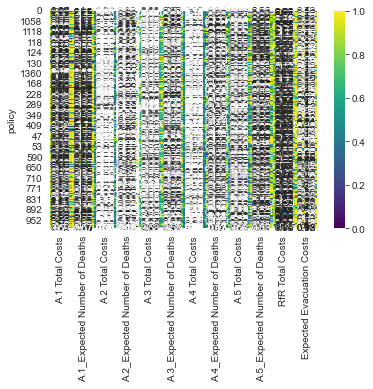

In [31]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

C:\Users\Thomas\miniconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


IndexError: list index out of range

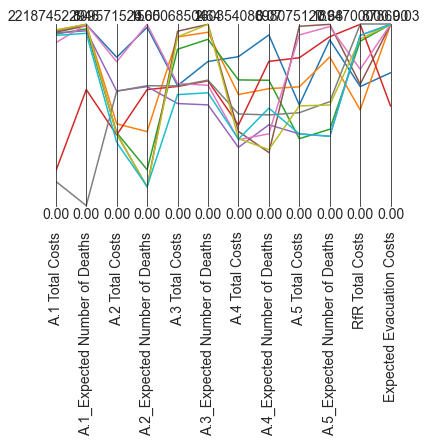

In [32]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [ ]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [ ]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18,12), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1], axes[0,2],
        axes[1,0], axes[1,1], axes[1,2]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))

    # Rotate x-axis labels slightly to make them redable
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()